# 1. Import Metadata for every Track

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
import glob
import sys
import re
import os

import utils
from utils import data_importer

import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [28]:
def metadata_importer(path):
    with open(path, 'r') as f:
        df = pd.read_csv(f)

    # change user id from float to str
    df['user_id'] = list(map(lambda x: '0' * (3 - len(str(int(x)))) + str(int(x)), df['user_id']))

    # change datetime from str to datetime.datetime
    df['end_time'] = list(map(lambda s: datetime.strptime(s, '%Y-%m-%d %H:%M:%S'), df['end_time'].values))

    print('Metadata import complete!')
    return df

In [29]:
csv_path = './metadata_df.csv'
df = metadata_importer(csv_path)
df

Metadata import complete!


,average_speed,average_acceleration,max_speed,max_acceleration,mode,user_id,end_time
0,63.956277,0.001430,118.710639,0.068488,train,010,2008-03-28 22:01:19
1,74.221753,0.001588,117.506273,0.074917,train,010,2008-03-29 10:03:00
2,75.022218,0.001541,115.419248,0.073340,train,010,2008-03-29 16:33:24
3,79.359841,0.004979,110.806526,0.064658,train,010,2008-03-30 02:46:32
4,60.461406,0.056342,116.947948,0.072975,train,010,2008-03-30 04:16:59
5,80.966227,0.004012,117.233138,0.079556,train,010,2008-03-30 07:55:28
6,103.415071,0.017394,111.463037,0.033182,train,010,2008-03-30 08:58:19
7,10.313803,0.027118,19.568245,0.051790,train,010,2008-03-30 09:09:42
8,61.650801,0.000207,108.011374,0.051775,train,010,2008-03-30 19:41:56
9,47.696436,0.069951,105.567567,0.029216,train,010,2008-03-30 23:25:31


# 2. Retrieve X and y

In [4]:
def label_encoding(y_orig):
    le = preprocessing.LabelEncoder()
    le.fit(y_orig)
    y_orig = le.transform(y_orig)

    return y_orig, le.classes_

In [5]:
X_orig = df.iloc[:, :4].values
y_orig = df.iloc[:, 4].values
y_orig, mode_classes = label_encoding(y_orig)

print('shape of X_orig: {}'.format(X_orig.shape))
print('shape of y_orig: {}'.format(y_orig.shape))

shape of X_orig: (13225, 4)
shape of y_orig: (13225,)


In [6]:
def convert_to_one_hot(Y, num_features):
    Y = np.eye(num_features)[Y.reshape(-1)].T
    return Y

In [7]:
X_orig = np.array(X_orig).reshape(X_orig.shape[0], -1).T
y_orig_one_hot = convert_to_one_hot(np.array(y_orig), len(mode_classes))

In [8]:
print("number of training examples = " + str(X_orig.shape[1]))
print("number of test examples = " + str(X_orig.shape[1]))
print("X shape: " + str(X_orig.shape))
print("y shape: " + str(y_orig_one_hot.shape))

number of training examples = 13225
number of test examples = 13225
X shape: (4, 13225)
y shape: (11, 13225)


In [9]:
def calculate_box_plot_characteristics(my_list: list):
    result = {}

    result["minimum"] = np.min(my_list)
    result["maximum"] = np.max(my_list)
    result["median"] = np.median(my_list)

    q1 = np.percentile(my_list, 25)
    q3 = np.percentile(my_list, 75)
    iqr = q3 - q1
    result["lower_quartile"] = q1
    result["upper_quartile"] = q3

    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    rpa_sort = np.sort(my_list)
    for i in range(len(rpa_sort)):
        if rpa_sort[i] > lower_whisker:
            result["lower_whisker"] = rpa_sort[i]
            break
    for i in reversed(range(len(rpa_sort))):
        if rpa_sort[i] < upper_whisker:
            result["upper_whisker"] = rpa_sort[i]
            break

    return result

In [10]:
# normalization
for i in range(len(X_orig)):
    X_orig[i] = X_orig[i] / calculate_box_plot_characteristics(X_orig[i])['upper_whisker']

# 3. Import Trained Net

In [11]:
def initialize_parameters(params_size: list):
    """
    Initializes parameters to build a neural network with tensorflow.

    Returns:
    parameters -- a dictionary of tensors containing list W and list b
    """

    W = [None for i in range(len(params_size) - 1)]
    b = [None for i in range(len(params_size) - 1)]

    for i in range(len(params_size) - 1):
        W[i] = tf.compat.v1.get_variable('W'+str(i), [params_size[i+1], params_size[i]], initializer = tf.contrib.layers.xavier_initializer())
        b[i] = tf.compat.v1.get_variable('b'+str(i), [params_size[i+1], 1], initializer = tf.zeros_initializer())

    parameters = {'W': W, 'b': b}

    return parameters

In [12]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: (LINEAR -> RELU) * k -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters list W and list b

    Returns:
    Z_out -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W = parameters['W']
    b = parameters['b']

    Z = [None for i in range(len(W) - 1)]
    A = [None for i in range(len(W) - 1)]

    for i in range(len(W)):
        if i == 0:
            Z[i] = tf.matmul(W[i], X) + b[i]
            A[i] = tf.nn.relu(Z[i])
        elif i != len(W) - 1:
            Z[i] = tf.matmul(W[i], A[i-1]) + b[i]
            A[i] = tf.nn.relu(Z[i])
        else:
            Z_out = tf.matmul(W[i], A[i-1]) + b[i]

    return Z_out

In [13]:
(n_x, m) = X_orig.shape
n_y = y_orig_one_hot.shape[0]
params_size = [4, 64, 128, 64, 32, 11]

X = tf.placeholder(tf.float32, [n_x, None], name='X')
Y = tf.placeholder(tf.float32, [n_y, None], name='Y')

parameters = initialize_parameters(params_size)
Z_out = forward_propagation(X, parameters)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./final/save_net'))
    correct_prediction = tf.equal(tf.argmax(Z_out), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_orig = accuracy.eval({X: X_orig, Y: y_orig_one_hot})
    predictions = Z_out.eval(feed_dict = {X: X_orig}).T

W0129 01:10:02.822307 10364 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [15]:
with open('./final/costs #0.txt', 'r')  as f:
    costs = f.readlines()
costs = list(map(float, costs[1:]))

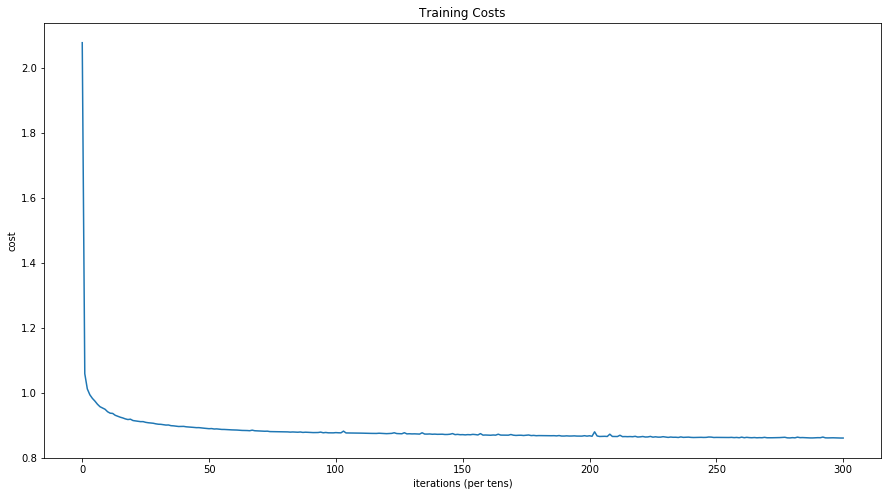

In [25]:
# plot the cost
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Training Costs")
plt.show()

# 4. Accuracy and Predictions

In [15]:
print("Accuracy of the network: %.2f %%" % (accuracy_orig * 100))

Accuracy of the network: 75.91 %


In [16]:
y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))
y_pred = np.array(y_pred)

In [21]:
confusion_matrix(y_orig, y_pred)

array([[   8,    4,    0,    3,    7,    0,    0,    0,    0,    2,    7],
       [   0, 1518,    0,   78,   23,    0,    0,    5,    0,    2,  294],
       [   0,    2,    0,    0,    1,    0,    0,    0,    0,    2,    5],
       [   0,  129,    0, 1551,  209,    0,    0,   16,   52,    9,  379],
       [   0,   54,    0,  192,  845,    0,    0,   22,   27,   31,  217],
       [   0,    0,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,    0,    0,    0,    0,    0,    0,    0,    0,    8],
       [   0,   27,    0,   28,  102,    0,    0,  363,   16,    9,  301],
       [   0,   22,    0,  154,  164,    0,    0,   17,  146,    8,   56],
       [   0,    4,    0,   12,   27,    0,    0,   14,   12,  246,   33],
       [   0,  240,    0,  108,   19,    0,    0,   19,    5,    6, 5362]],
      dtype=int64)

In [23]:
metrics.recall_score(y_orig, y_pred, average='macro')

0.4221291789636437

In [25]:
metrics.precision_score(y_orig, y_pred, average='macro')

0.5491001396607221

# 5. Further Possible Optimization
- find better hyperparameters
- try dropout regularization
- filter original data